<a href="https://colab.research.google.com/github/guidoivetta/clustering-TM-2021/blob/main/Clustering_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!python -m spacy download es_core_news_md

     |████████████████████████████████| 78.4 MB 1.3 MB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.2.5-py3-none-any.whl size=79649483 sha256=0dace78e26ef8c4ea13ec630cf1812951f25f051baec2c54969eeb7bb7016629
  Stored in directory: /tmp/pip-ephem-wheel-cache-0cgvjmz2/wheels/d8/f5/92/ee8a4f74fac67775fbc0314b1c9ae4694f4180437f6fc3dd1c
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import nltk
nltk.download('punkt')
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load dataset

In [2]:
nlp = spacy.load('es_core_news_md')

In [5]:
drive_path = '/content/drive/MyDrive/Text-Mining/'
filename = "lavoztextodump.txt"
text_file = open(drive_path+filename, "r")
dataset = text_file.read()
text_file.close()

In [6]:
doc = nlp(dataset[:1000000])

# Cleaning up dataset

Longer sentences are used because more interesting linguistic contructions are possible and the larger context provides more features for each word. 

In [51]:
# Only sents with more than 10 words are considered
longer_sents = [sent for sent in doc.sents if len(sent) > 10]

lemmas = []
for sent in longer_sents:
  for word in sent:
    if word.is_alpha:
      lemmas.append(word.lemma_)

# lemma_counter stores the number of times each lemma has ocurred
lemma_counter = Counter(lemmas)

# Six groups of features are added: 

## 1.   Part-of-speech:

    e.g. PROPN, AUX, VERB, ADP, etc.

* ### Why?

    Consider the sentences:
      · Please book my flight for New York
      · I like to read a book on New York 
    
    In both sentences, the keyword book is used, but in sentence one, it is used as a verb. While in sentence two it is used as a noun.

    If two words have similar part-of-speech usages we might want to cluster them together.

## 2.   Dependency:

    e.g. nsubj, aux, ROOT, prep, etc.

* ### Why?

    Dependency grammar organizes the words of a sentence according to their dependency. One of the words in the sentence act as a root and all the other words are directly or indirectly linked to the root using their dependencies. These dependencies represent the relationship among the words in a sentence.

    The dependency grammar is used to understand the structure and semantic dependencies between the words.

## 3.   Tag:

    e.g. NNP, VBZ, VBG, NNP, etc.

* ### Why?

    Spacy gives a detailed part-of-speech tag. This adds more specific information with the same purpose as part-of-speech.


## 4.   Dependency triples:

    e.g. TRIPLE_pescado_nsubj_comer, etc.

* ### Why?

    Dependency triples are a well-known tool to associate the dependency feature with the word's HEAD.


## 5.   Entity Type:

    e.g. GPE, PERSON, LOC, PERCENT, etc.

* ### Why?

    A named entity is a “real-world object” that’s assigned a name – for example, a person, a country, a product or a book title. Spacy can recognize various types of named entities in a document, by asking the model for a prediction. 
    
    By calculating the number of times each word was assigned one specific entity type, we can group the distinct types closer together.
    

## 6.   Context:

    All other lemmas in the same sent which surpass `threshold_c` are considered. If they are numerical values they are grouped in a `NUM__` feature.


Each distinct lemma in the dataset will have a count of each subfeature. This will be our guide to find word similarity and clusters in the rest of the notebook.

In [53]:
# features_dict has lemmas as keys and a dict with its features as values
features_dict = {}

# Lemmas with less than threshold_l number of ocurrences will not be considered
threshold_l = 10

# Context words with less than threshold_c number of ocurrences will not be considered
threshold_c = 50

for sent in longer_sents:
  for word in sent:
    l = word.lemma_
    if lemma_counter[l] < threshold_l or not word.is_alpha:
        continue
    
    if not l in features_dict:
      # New lemma
      l_features = {}
    else:
      # Known lemma, we must update its features
      l_features = features_dict[l]

    # Adding Part-of-speech feature
    pos = "POS__" + word.pos_
    if not pos in l_features:
        l_features[pos] = 0
    l_features[pos] += 1

    # Adding dependency feature
    dep = "DEP__" + word.dep_
    if not dep in l_features:
        l_features[dep] = 0
    l_features[dep] += 1

    # Adding tag feature
    tag = "TAG__" + word.tag_
    if not tag in l_features:
        l_features[tag] = 0
    l_features[tag] += 1

    # Adding dependency triples feature
    dep_triple = "TRIPLE_" + l + "_" + word.dep_ + "_" + word.head.lemma_
    if not dep_triple in l_features:
        l_features[dep_triple] = 0
    l_features[dep_triple] += 1

    # Adding entity type feature
    ent_type = word.ent_type_
    if ent_type is not '':
      if not ent_type in l_features:
        l_features[ent_type] = 0
      l_features[ent_type] += 1
    
    # Adding context feature
    # Here we define context as words in the same sent
    for other_word in sent:
      if other_word == word:
        continue
      if lemma_counter[other_word.lemma_] > threshold_c:
        if other_word.like_num:
          context = "NUM__"
        else:
          context = other_word.lemma_
        if not context in l_features:
            l_features[context] = 0
        l_features[context] += 1

    features_dict[l] = l_features

In [74]:
# features_matrix will have a similar structure as features_dict
# It will be used as input for a DictVectorizer
features_matrix = []

# lemma_dict has lemmas as keys and their lid (lemma id) as values
lemma_lid_dict = {}
lid = 0
for d in features_dict:
    if len(d) > 0:
        lemma_lid_dict[d] = lid
        lid += 1
        features_matrix.append(features_dict[d])

# Handling matrix

Transforms lists of feature-value mappings to vectors.

This transformer turns lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays or scipy.sparse matrices for use with scikit-learn estimators.

When feature values are strings, this transformer will do a binary one-hot (aka one-of-K) coding: one boolean-valued feature is constructed for each of the possible string values that the feature can take on. For instance, a feature “f” that can take on the values “ham” and “spam” will become two features in the output, one signifying “f=ham”, the other “f=spam”.

If a feature value is a sequence or set of strings, this transformer will iterate over the values and will count the occurrences of each string value.

However, note that this transformer will only do a binary one-hot encoding when feature values are of type string. If categorical features are represented as numeric values such as int or iterables of strings, the DictVectorizer can be followed by OneHotEncoder to complete binary one-hot encoding.

Features that do not occur in a sample (mapping) will have a zero value in the resulting array/matrix.

In [75]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features_matrix)

In [76]:
# Normalization is achieved by dividing by the matrix max value
matrix_normed = matrix / matrix.max(axis=0)

# Variances of each feature are calculated
variances = np.square(matrix_normed).mean(axis=0)-np.square(matrix_normed.mean(axis=0))

# Features with less variance than threshold_v will be discarded
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

# Data visualization

T-distributed Stochastic Neighbor Embedding.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

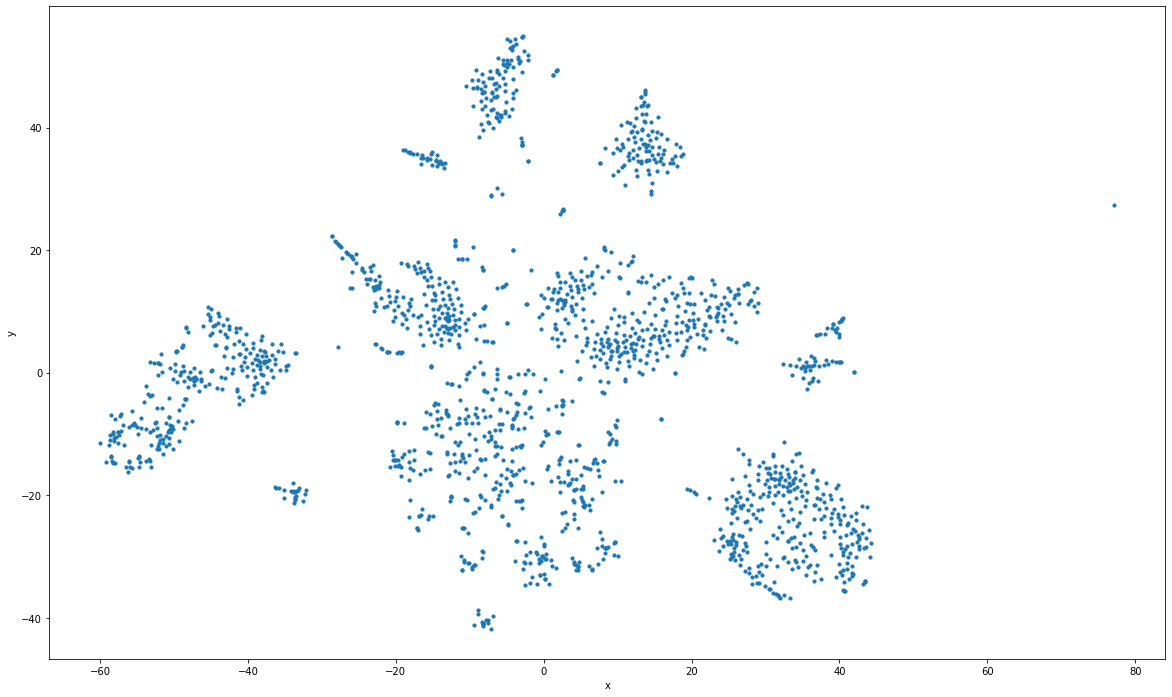

In [77]:
# t-SNE is used to visualize our high-dimensional red_matrix
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y"]
)

pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

# Clustering

In [78]:
def clustering(k, matrix):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance)
    clusters = clusterer.cluster(matrix, True)
    return clusters

# k-means with cosine distances is used for clustering
n_clusters = 150
clusters = clustering(n_clusters, red_matrix)

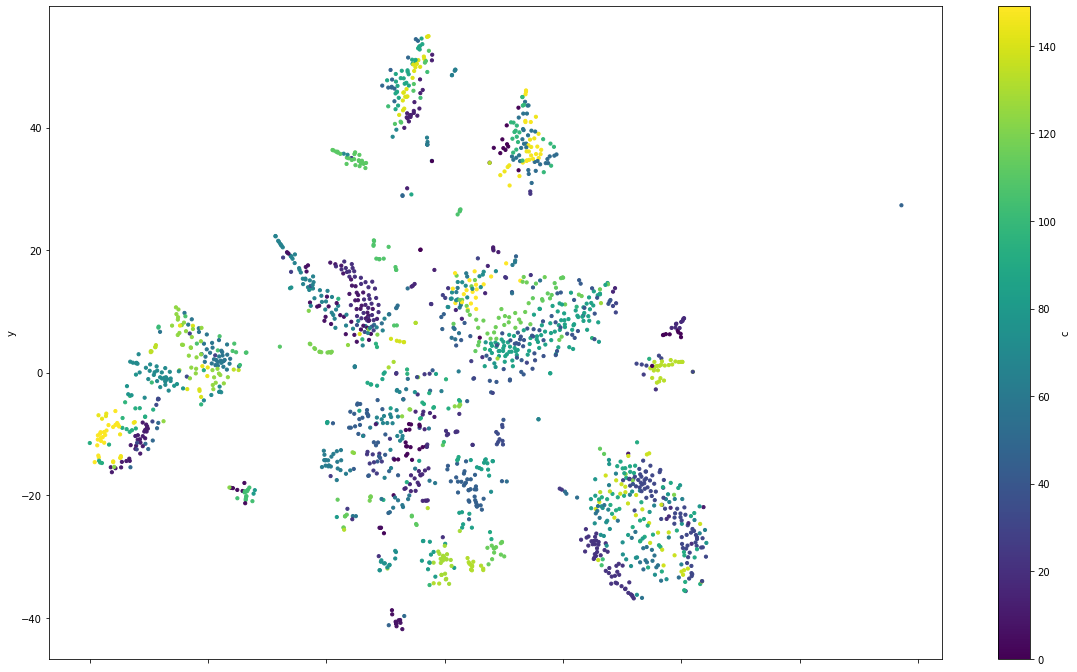

In [79]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[lemma_lid_dict[word]], clusters[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y", "c"]
)

pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [80]:
# Prints lemma's cluster and plots area around it
def show_neighbourhood(l, radius):
  pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[lemma_lid_dict[word]], clusters[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y", "c"]
  )

  l_x = pointscluster.x[lemma_lid_dict[l]]
  l_y = pointscluster.y[lemma_lid_dict[l]]
  x_lower_bound = l_x-radius
  x_higher_bound = l_x+radius
  y_lower_bound = l_y-radius
  y_higher_bound = l_y+radius
  
  pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(10, 6))
  for i, point in pointscluster.iterrows():
    if x_lower_bound <= point.x <= x_higher_bound and y_lower_bound <= point.y <= y_higher_bound:
      plt.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=12)
  
  plt.xlim(x_lower_bound, x_higher_bound)
  plt.ylim(y_lower_bound, y_higher_bound)

  l_cluster = [lemma for lemma in lemma_lid_dict if clusters[lemma_lid_dict[lemma]] == clusters[lemma_lid_dict[l]]]

  print(f'Cluster for {l}:')
  print(f'\t{l_cluster}\n')

  print(f'Neighbourhood:\n')

Cluster for ocurrir:
	['faltar', 'venir', 'ocurrir', 'suceder', 'funcionar', 'existir', 'romper']

Neighbourhood:



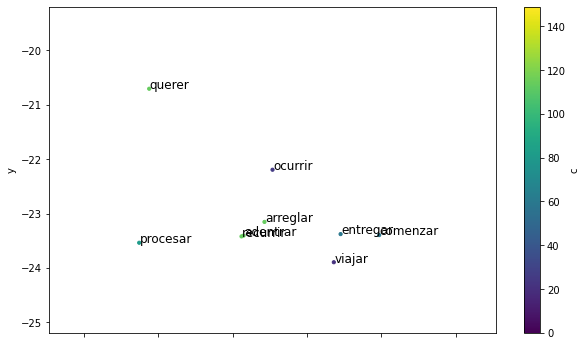

In [81]:
show_neighbourhood('ocurrir', radius=3)

Cluster for sábado:
	['sábado', 'miércoles', 'martes', 'viernes', 'lunes', 'jueves', 'enero', 'julio', 'noviembre', 'domingo']

Neighbourhood:



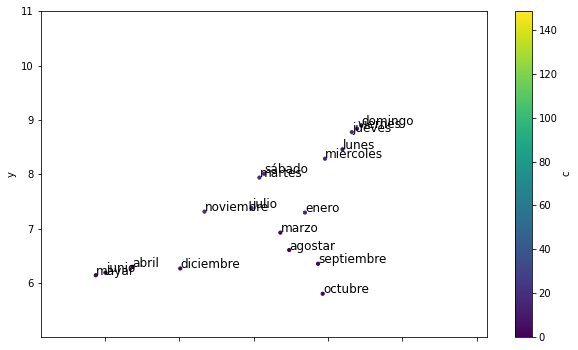

In [82]:
show_neighbourhood('sábado', radius=3)

Cluster for Facultad:
	['Ministerio', 'Facultad', 'Escuela', 'Colegio', 'Filosofía']

Neighbourhood:



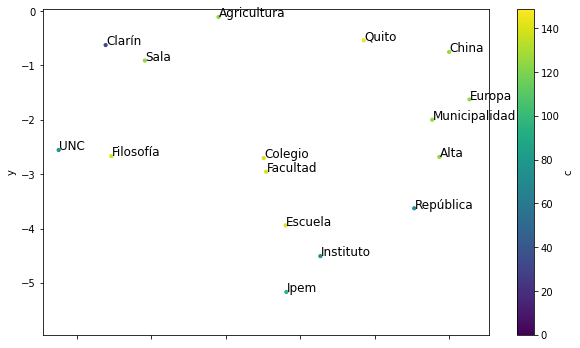

In [83]:
show_neighbourhood('Facultad', radius=3)

Cluster for Brasil:
	['Secretaría', 'Marcos', 'Voz', 'PJ', 'Concejo', 'Curitiba', 'Brasilia', 'Brasil', 'Palacio']

Neighbourhood:



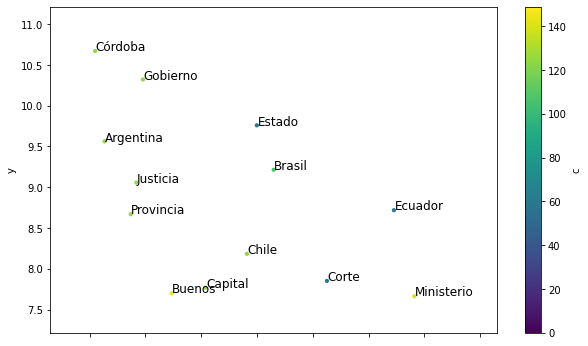

In [84]:
show_neighbourhood('Brasil', radius=2)

# Embeddings

## Word2Vec

In [85]:
from gensim.models import Word2Vec

sentences = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(dataset[:1000000])]
model = Word2Vec(sentences, min_count=10)

In [86]:
model.wv.most_similar('lunes', topn=10)

[('debate', 0.9996885657310486),
 ('pública', 0.9996858835220337),
 ('dentro', 0.9996639490127563),
 ('nueva', 0.9996500015258789),
 ('Sala', 0.9996330738067627),
 ('constitucional', 0.9996153116226196),
 ('comenzó', 0.9996105432510376),
 ('habría', 0.9996013641357422),
 ('protesta', 0.9996013045310974),
 ('final', 0.9995912313461304)]

## SVD (Singular value decomposition)

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.



In [87]:
from sklearn.decomposition import TruncatedSVD
# reducing data to 10 dimensions
svd = TruncatedSVD(n_components=10)
svd_matrix = svd.fit_transform(red_matrix)

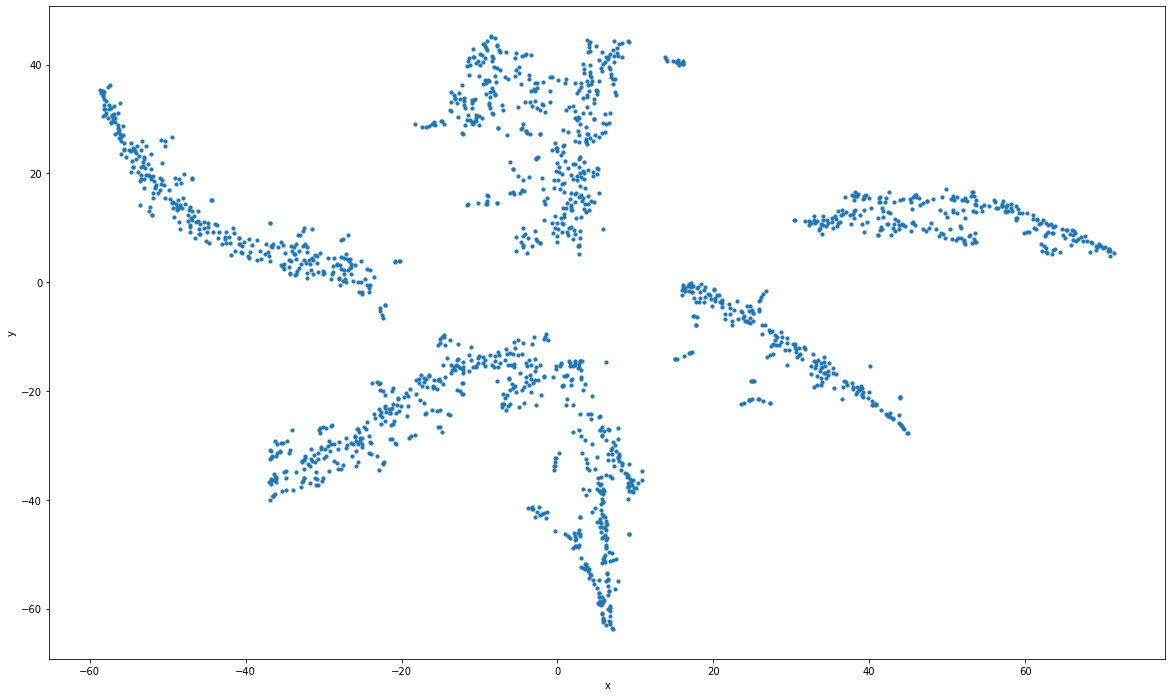

In [88]:
# t-SNE is used to visualize our high-dimensional svd_matrix
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(svd_matrix)

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y"]
)

pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [89]:
# k-means with cosine distances is used for clustering
n_clusters = 150
clusters_svd = clustering(n_clusters, svd_matrix)

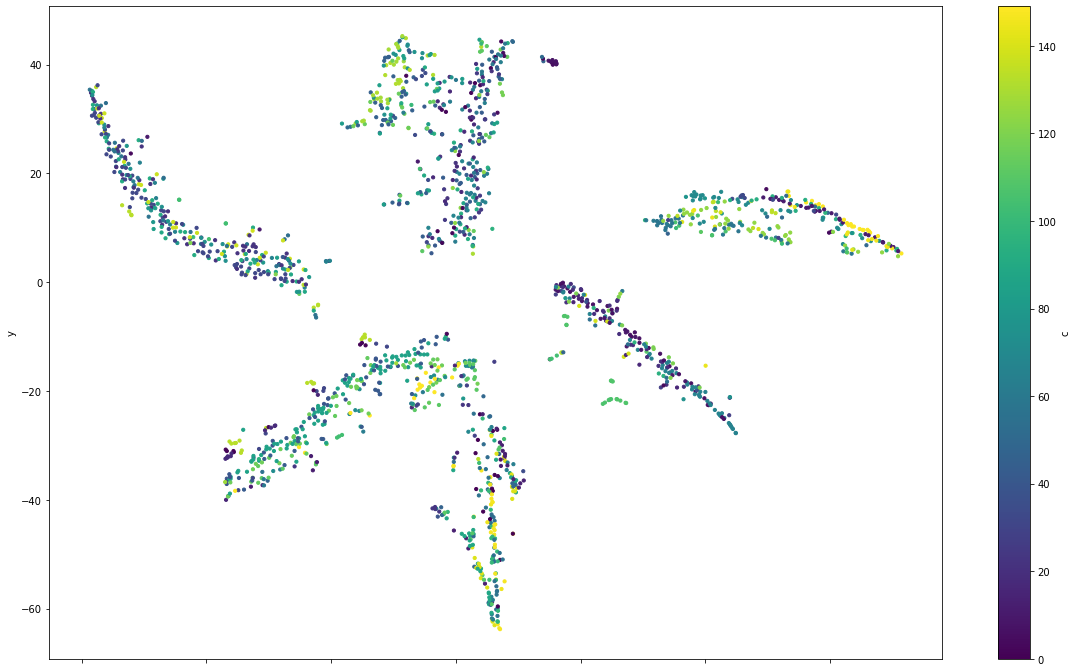

In [90]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[lemma_lid_dict[word]], clusters[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y", "c"]
)

pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

Cluster for sábado:
	['sábado', 'miércoles', 'martes', 'viernes', 'lunes', 'jueves', 'enero', 'julio', 'noviembre', 'domingo']

Neighbourhood:



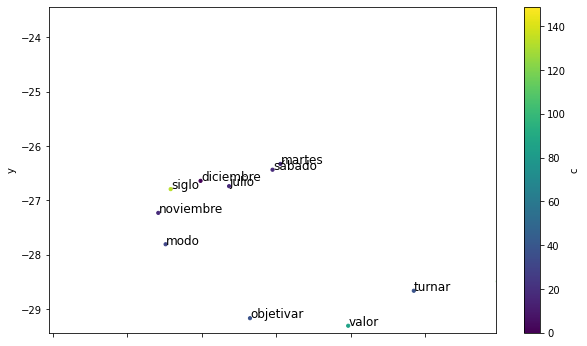

In [91]:
show_neighbourhood('sábado', radius=3)

Cluster for Facultad:
	['Ministerio', 'Facultad', 'Escuela', 'Colegio', 'Filosofía']

Neighbourhood:



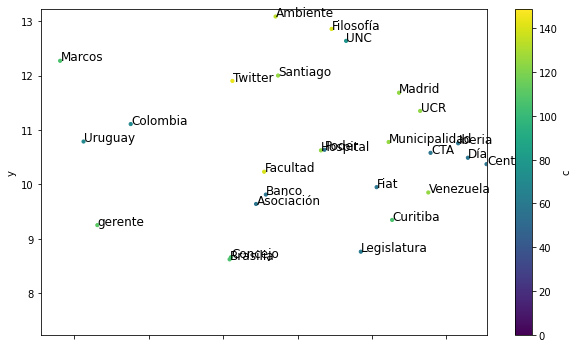

In [92]:
show_neighbourhood('Facultad', radius=3)

Cluster for Brasil:
	['Secretaría', 'Marcos', 'Voz', 'PJ', 'Concejo', 'Curitiba', 'Brasilia', 'Brasil', 'Palacio']

Neighbourhood:



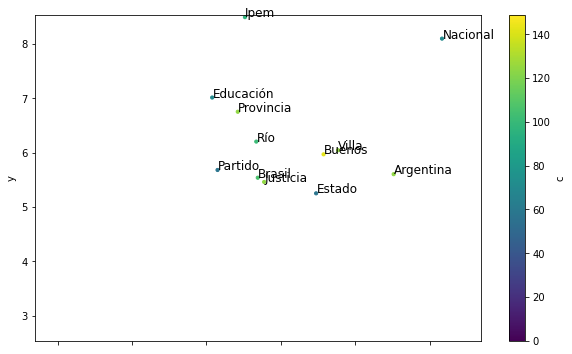

In [93]:
show_neighbourhood('Brasil', radius=3)

Cluster for Filosofía:
	['Ministerio', 'Facultad', 'Escuela', 'Colegio', 'Filosofía']

Neighbourhood:



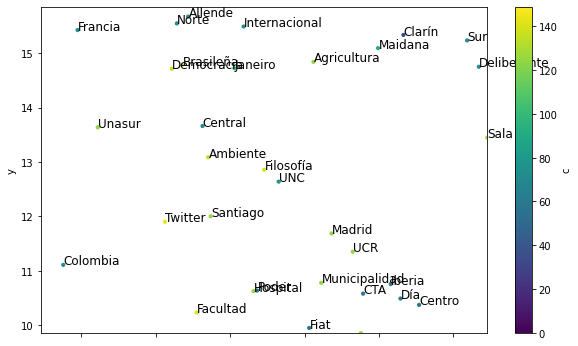

In [94]:
show_neighbourhood('Filosofía', radius=3)